# 06 - 分组和虚拟回归


## 分组数据回归

并非所有数据点都是一样的。 如果我们再次查看我们的 ENEM 数据集，相比小规模学校的分数，我们更相信规模较大的学校的分数。 这并不是说大型学校更好或什么， 而只是因为它们的较大规模意味着更小的方差。

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf

style.use("fivethirtyeight")

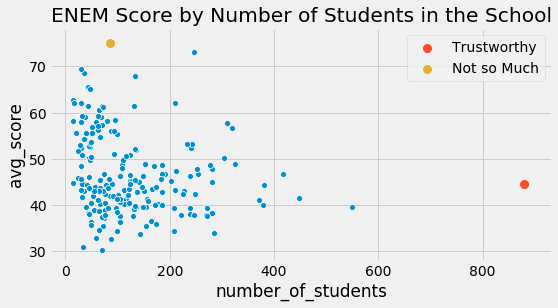

In [2]:
np.random.seed(876)
enem = pd.read_csv("./data/enem_scores.csv").sample(200)
plt.figure(figsize=(8,4))
sns.scatterplot(y="avg_score", x="number_of_students", data=enem)
sns.scatterplot(y="avg_score", x="number_of_students", s=100, label="Trustworthy",
                data=enem.query(f"number_of_students=={enem.number_of_students.max()}"))
sns.scatterplot(y="avg_score", x="number_of_students", s=100, label="Not so Much",
                data=enem.query(f"avg_score=={enem.avg_score.max()}"))
plt.title("ENEM Score by Number of Students in the School");

在上面的数据中，直观上，左边的点对我的模型的影响应该比右边的点小。本质上，右边的点实际上是许多其他数据点组合成一个。如果我们可以拆分它们并对未分组的数据进行线性回归，那么它们对模型估计的贡献确实比左侧的未捆绑点要大得多。

这种同时具有一个低方差区域和另一个高方差区域的现象称为**异方差**。简而言之，异方差是指因变量的方差在各个特征变量的值域内方差不是恒定的。在上面的例子中，我们可以看到因变量方差随着特征样本大小的增加而减少。再举一个我们有异方差的例子，如果你按年龄绘制工资，你会发现老年人的工资差异大于年轻人的工资差异。但是，到目前为止，方差不同的最常见原因是分组数据。

像上面这样的分组数据在数据分析中非常常见。原因之一是保密。政府和公司不能泄露个人数据，因为这会违反他们必须遵守的数据隐私要求。如果他们需要将数据导出给外部研究人员，他们只能通过对数据进行分组的方式来完成。这样，个人集合在一起，不再是唯一可识别的。

对我们来说幸运的是，回归可以很好地处理这些类型的数据。要了解如何做，让我们首先采用一些未分组的数据，例如我们在工资和教育方面的数据。在这些数据集中，每个工人对应一行数据，所以我们知道这个数据集中每个人的工资以及他或她有多少年的教育。

In [3]:
wage = pd.read_csv("./data/wage.csv")[["wage", "lhwage", "educ", "IQ"]]

wage.head()

,wage,lhwage,educ,IQ
0,769,2.956212,12,93
1,808,2.782539,18,119
2,825,3.026504,14,108
3,650,2.788093,12,96
4,562,2.642622,11,74


如果我们运行一个回归模型来找出教育与对数小时工资的关系，我们会得到以下结果。

In [4]:
model_1 = smf.ols('lhwage ~ educ', data=wage).fit()
model_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.2954,0.089,25.754,0.000,2.121,2.470
educ,0.0529,0.007,8.107,0.000,0.040,0.066


现在，让我们暂时假设这些数据有某种保密限制， 它的提供者无法提供个性化数据。 因此，我们请他将每个人按受教育年限分组，并只给我们平均对数小时工资和每个组中的人数。 这让我们只剩下 10 个数据点。

In [5]:
group_wage = (wage
              .assign(count=1)
              .groupby("educ")
              .agg({"lhwage":"mean", "count":"count"})
              .reset_index())

group_wage

,educ,lhwage,count
0,9,2.856475,10
1,10,2.786911,35
2,11,2.855997,43
3,12,2.922168,393
4,13,3.021182,85
5,14,3.042352,77
6,15,3.090766,45
7,16,3.176184,150
8,17,3.246566,40
9,18,3.144257,57


不要怕！ 回归不需要大数据就可以工作！ 我们可以做的是为我们的线性回归模型提供权重。 这样，相对样本量稍小的群体，模型会更多地考虑样本量更大的群体。 请注意我是如何用 smf.wls 替换 smf.ols 的，以获得加权最小二乘法。 新方法会让一切变得不同，虽然这点不容易被注意到。

In [6]:
model_2 = smf.wls('lhwage ~ educ', data=group_wage, weights=group_wage["count"]).fit()
model_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.2954,0.078,29.327,0.000,2.115,2.476
educ,0.0529,0.006,9.231,0.000,0.040,0.066


注意分组模型中 edu 的参数估计与未分组数据中的参数估计完全相同。 此外，即使只有 10 个数据点，我们也设法获得了具有统计意义的系数。 那是因为，虽然我们的点数较少，但分组也大大降低了方差。 还要注意参数估计的标准误差是变得大了一点，t 统计量也是如此。 那是因为丢失了一些关于方差的信息，所以我们必须更加保守。 一旦我们对数据进行分组，我们不知道每个组内的方差有多大。 将上面的结果与我们在下面的非加权模型中得到的结果进行比较。

In [7]:
model_3 = smf.ols('lhwage ~ educ', data=group_wage).fit()
model_3.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.3650,0.082,28.988,0.000,2.177,2.553
educ,0.0481,0.006,8.136,0.000,0.034,0.062


参数估计较大。 这里发生的事情是回归对所有点施加了相等的权重。 如果我们沿着分组点绘制模型，我们会看到非加权模型对左下角的小点的重视程度高于应有的重视程度。 因此，该模型的回归线具有更高的斜率。

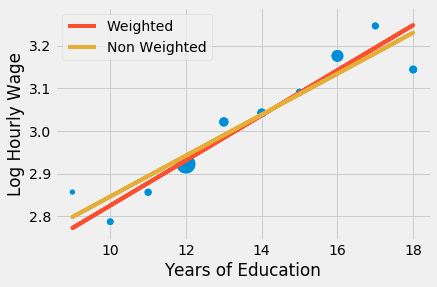

In [8]:
sns.scatterplot(x="educ", y = "lhwage", size="count", legend=False, data=group_wage, sizes=(40, 400))
plt.plot(wage["educ"], model_2.predict(wage["educ"]), c="C1", label = "Weighted")
plt.plot(wage["educ"], model_3.predict(wage["educ"]), c="C2", label = "Non Weighted")
plt.xlabel("Years of Education")
plt.ylabel("Log Hourly Wage")
plt.legend();

归根结底，回归是这个奇妙的工具，可以处理单个数据或聚合数据，但在最后一种情况下您必须使用权重。 要使用加权回归，您需要平均统计量。 不是总和，不是标准差，不是中位数，而是平均值！ 对于自变量和因变量都需要这么处理。 除了单一自变量回归的情况外，分组数据的加权回归结果与未分组数据的回归结果不会完全匹配，但会非常相似。

![img](./data/img/dummy/heterosk.png)

我将用在分组数据模型中使用附加自变量的最后一个例子来结束。

In [9]:
group_wage = (wage
              .assign(count=1)
              .groupby("educ")
              .agg({"lhwage":"mean", "IQ":"mean", "count":"count"})
              .reset_index())

model_4 = smf.wls('lhwage ~ educ + IQ', data=group_wage, weights=group_wage["count"]).fit()
print("Number of observations:", model_4.nobs)
model_4.summary().tables[1]

Number of observations: 10.0


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.8821,0.324,5.800,0.001,1.115,2.649
educ,0.0257,0.021,1.198,0.270,-0.025,0.077
IQ,0.0077,0.006,1.309,0.232,-0.006,0.022


在此示例中，除了先前添加的教育年限之外，我们还包括 IQ 作为一个特征。运作机制几乎相同：获取均值并计数，回归均值并将计数用作权重。

## 虚拟变量回归

虚拟变量是我们编码为二进制列的分类变量。例如，假设您有一个希望包含在模型中的性别变量。该变量被编码为 3 个类别：男性、女性和其他性别。

|性别|
|------|
|男 |
|女|
|女|
|其他 |
|男 |

由于我们的模型只接受数值，我们需要将这个类别转换为数字。在线性回归中，我们为此使用了虚拟变量。我们将每个变量编码为 0/1 列，表示类别的存在。我们还将其中一个类别作为基本类别。这是必要的，因为最后一个类别是其他类别的线性组合。换句话说，如果有人向我们提供其他类别的信息，我们就可以知道最后一个类别。在我们的示例中，如果某人既不是女性也不是其他性别，我们可以推断该人的类别是男性。

|性别|女性|其他|
|------|:-----|:----|
|男性 |0|0|
|女性|1|0|
|女性|1|0|
|其他 |0|1|
|男性 |0|0|

在处理 A/B 测试时，我们已经处理了一种简单形式的虚拟回归。更一般地，当我们处理二元处理时，我们将其表示为虚拟变量。在这种情况下，**该虚拟变量的回归系数是回归线中截距的增量**，或处理和未处理之间的均值差异。

为了更具体地说明这一点，请考虑估计 12 年级毕业对小时工资的影响的问题（让我们暂时忽略混杂因素）。在下面的代码中，我们创建了一个处理虚拟变量“T”，指示受教育年限是否大于 12。

In [10]:
wage = (pd.read_csv("./data/wage.csv")
        .assign(hwage=lambda d: d["wage"] / d["hours"])
        .assign(T=lambda d: (d["educ"] > 12).astype(int)))

wage[["hwage", "IQ", "T"]].head()

,hwage,IQ,T
0,19.225,93,0
1,16.160,119,1
2,20.625,108,1
3,16.250,96,0
4,14.050,74,0


假人作为一种开关工作。 在我们的示例中，如果启动虚拟机，则预测值是截距加上虚拟机系数。 如果假人关闭，则预测值只是截距。

In [11]:
smf.ols('hwage ~ T', data=wage).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,19.9405,0.436,45.685,0.000,19.084,20.797
T,4.9044,0.626,7.830,0.000,3.675,6.134


在这种情况下，当此人未完成 12 年级（假关闭）时，平均收入为 19.9。当他或她完成 12 年级（虚拟开启）时，预测值或平均收入为 24.8449 (19.9405 + 4.9044)。因此，虚拟系数捕捉了均值的差异，在我们的案例中为 4.9044。

更正式地，当因变量是二元变量时，就像治疗指标的情况一样，回归完美地捕捉了 ATE。这是因为回归是条件期望函数 (CEF) \\(E[Y|X]\\) 的线性近似，在这种特殊情况下，CEF 是线性的。即，我们可以定义 \\(E[Y_i|T_i=0]=\alpha\\) 和 \\(E[Y_i|T_i=1] = \alpha + \beta\\)，这导致以下 CEF

$
E[Y_i|T_i] = E[Y_i|T_i=0] + \beta T_i = \alpha + \beta T_i
$

和 \\(\beta\\) 是随机数据的平均值或 ATE 的差异

$
\beta = [Y_i|T_i=1] - [Y_i|T_i=0]
$

如果我们使用额外的变量，虚拟系数将成为 **条件** 均值差异。例如，假设我们将 IQ 添加到之前的模型中。现在，虚拟系数告诉我们 12 年级 ** 在保持 IQ 固定**的情况下应该期望增加多少。如果我们绘制预测图，我们将看到两条平行线。从一行跳到下一行表示我们完成 12 年级的预期数量。他们还说效果是恒定的。无论您的智商如何，每个人都从 12 年级毕业中受益。

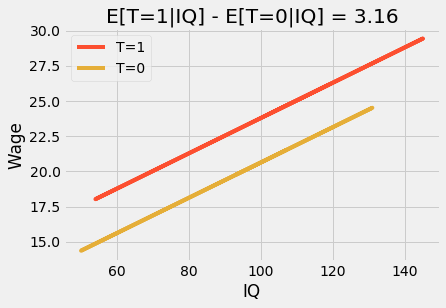

In [12]:
m = smf.ols('hwage ~ T+IQ', data=wage).fit()
plt_df = wage.assign(y_hat = m.fittedvalues)

plt.plot(plt_df.query("T==1")["IQ"], plt_df.query("T==1")["y_hat"], c="C1", label="T=1")
plt.plot(plt_df.query("T==0")["IQ"], plt_df.query("T==0")["y_hat"], c="C2", label="T=0")
plt.title(f"E[T=1|IQ] - E[T=0|IQ] = {round(m.params['T'], 2)}")
plt.ylabel("Wage")
plt.xlabel("IQ")
plt.legend();

如果我们把这个模型放到一个方程中，我们就会明白为什么：

$
工资_i = \beta_0 + \beta_1T_i + \beta_2 IQ_i + e_i
$

这里，\\(\beta_1\\) 是均值的条件差，它是一个常数值，在我们的例子中是 3.16。我们可以通过添加交互项来使这个模型更加灵活。

$
工资_i = \beta_0 + \beta_1T_i + \beta_2 IQ_i + \beta_3 IQ_i * T_i + e_i
$

事情变得有点复杂，所以让我们看看每个参数在这个模型中的含义。首先，截取 \\(\beta_0\\)。这个坏男孩没有特别有趣的解释。这是治疗为零（此人未从 12 年级毕业）且 IQ 为零时的预期工资。由于我们不希望任何人的 IQ 为零（实际上……没关系），因此该参数不是很有意义。现在，当我们转向 \\(\beta_1\\) 时，我们遇到了类似的情况。这个参数是我们在完成 12 年级 **当 IQ 为零**时应该期望增加多少工资。再说一次，由于智商永远不会为零，因此它没有特别有趣的含义。现在， \\(\beta_2\\) 更有趣一些。它告诉我们 IQ 增加了多少 **未接受治疗的**的工资。所以，在我们的例子中，它类似于 0.11。这意味着每增加 1 个 IQ 点，未完成 12 年级的人应该期望每小时增加 11 美分。最后，最有趣的参数是\\(\beta_3\\)。它告诉我们 IQ 对 12 年级毕业的影响有多大。在我们的例子中，这个参数是 0.024，这意味着对于每一个额外的 IQ 点，从 12 年级毕业会给 2 美分。这可能看起来不多，但比较一下 60IQ 和 140IQ 的人。第一个将获得 1.44 的工资增长（60 * 0.024），而智商为 140 的人从 12 年级毕业时将获得额外的 3.36 美元（60 * 0.024）。

用简单的建模术语来说，这个交互项允许治疗效果根据特征的级别（在这个例子中只有 IQ）而改变。结果是，如果我们绘制预测线，我们将看到它们不再平行，并且那些 12 年级 (T=1) 毕业的人在 IQ 上有更高的斜率，高智商比低智商受益更多。这有时被称为效果修改或异质治疗效果。

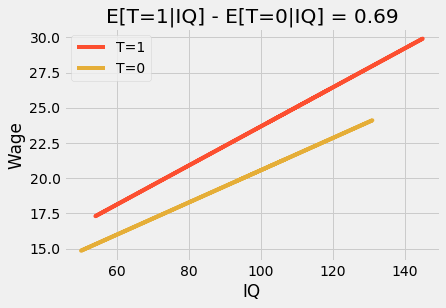

In [13]:
m = smf.ols('hwage ~ T*IQ', data=wage).fit()
plt_df = wage.assign(y_hat = m.fittedvalues)

plt.plot(plt_df.query("T==1")["IQ"], plt_df.query("T==1")["y_hat"], c="C1", label="T=1")
plt.plot(plt_df.query("T==0")["IQ"], plt_df.query("T==0")["y_hat"], c="C2", label="T=0")
plt.title(f"E[T=1|IQ] - E[T=0|IQ] = {round(m.params['T'], 2)}")
plt.ylabel("Wage")
plt.xlabel("IQ")
plt.legend();

最后，让我们看看我们模型中的所有变量都是哑元的情况。 为此，我们将 IQ 离散为 4 个 bin，并将受教育年限视为一个类别。

In [14]:
wage_ed_bins = (wage
                .assign(IQ_bins = lambda d: pd.qcut(d["IQ"], q=4, labels=range(4)))
                [["hwage", "educ", "IQ_bins"]])

wage_ed_bins.head()

,hwage,educ,IQ_bins
0,19.225,12,1
1,16.160,18,3
2,20.625,14,2
3,16.250,12,1
4,14.050,11,0


将教育视为一个类别，我们不再将教育的效果限制在单个参数上。 相反，我们允许每一年的教育都有自己独特的影响。 通过这样做，我们获得了灵活性，因为教育的效果不再是参数化的。 这个模型只是计算每一年教育的平均工资。

In [15]:
model_dummy = smf.ols('hwage ~ C(educ)', data=wage).fit()
model_dummy.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,18.5600,3.011,6.164,0.000,12.651,24.469
C(educ)[T.10],-0.7874,3.414,-0.231,0.818,-7.488,5.913
C(educ)[T.11],0.1084,3.343,0.032,0.974,-6.452,6.669
C(educ)[T.12],1.7479,3.049,0.573,0.567,-4.236,7.732
C(educ)[T.13],4.3290,3.183,1.360,0.174,-1.918,10.576
C(educ)[T.14],4.0888,3.200,1.278,0.202,-2.192,10.370
C(educ)[T.15],6.3013,3.329,1.893,0.059,-0.231,12.834
C(educ)[T.16],7.2225,3.110,2.323,0.020,1.120,13.325
C(educ)[T.17],9.5905,3.366,2.849,0.004,2.984,16.197
C(educ)[T.18],7.3681,3.264,2.257,0.024,0.962,13.775


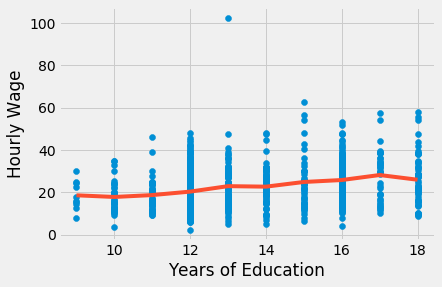

In [16]:
plt.scatter(wage["educ"], wage["hwage"])
plt.plot(wage["educ"].sort_values(), model_dummy.predict(wage["educ"].sort_values()), c="C1")
plt.xlabel("Years of Education")
plt.ylabel("Hourly Wage");

首先，请注意这如何消除关于教育如何影响工资的功能形式的任何假设。 我们不再需要担心日志。 本质上，这个模型是完全非参数化的。 它所做的只是计算每一年教育的样本平均工资。 这可以在上图中看到，其中拟合线没有特定形式。 相反，是对每一年教育的样本均值进行插值。 我们还可以通过重构一个参数来看到这一点，例如 17 年教育的参数。 对于这个模型，它是“9.5905”。 下面，我们可以看到基线教育年限 (9) 与 17 年的个人之间的差异

$
\beta_{17} = E[Y|T=17]-E[Y|T=9]
$

权衡是，当我们允许这种灵活性时，我们会失去统计意义。 请注意某些年份的 p 值有多大。

In [17]:
t1 = wage.query("educ==17")["hwage"]
t0 = wage.query("educ==9")["hwage"]
print("E[Y|T=9]:", t0.mean())
print("E[Y|T=17]-E[Y|T=9]:", t1.mean() - t0.mean())

E[Y|T=9]: 18.56
E[Y|T=17]-E[Y|T=9]: 9.59047236235352


如果我们在模型中包含更多的虚拟协变量，则教育参数成为对每个虚拟组影响的加权平均值：

$
E\{ \ (E[Y_i|T=1, Group_i] - E[Y_i|T=0, Group_i])w(Group_i) \ \}
$

\\(w(Group_i)\\) 并不完全正确，而是与组 \\(Var(T_i|Group_i)\\) 中处理的方差成正比。 由此产生的一个自然问题是，为什么不使用完整的非参数估计量，其中组权重是样本量？ 这确实是一个有效的估计量，但它不是回归所做的。 通过使用治疗方差，回归将更多的权重放在治疗变化很大的组上。 这很直观。 如果治疗几乎是恒定的（比如 1 个治疗而其他所有人都未治疗），则其样本大小无关紧要。 它不会提供有关治疗效果的太多信息。

In [18]:
model_dummy_2 = smf.ols('hwage ~ C(educ) + C(IQ_bins)', data=wage_ed_bins).fit()
model_dummy_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,18.4178,2.991,6.158,0.000,12.548,24.288
C(educ)[T.10],-1.2149,3.392,-0.358,0.720,-7.872,5.442
C(educ)[T.11],-0.4687,3.332,-0.141,0.888,-7.008,6.070
C(educ)[T.12],0.3400,3.059,0.111,0.912,-5.664,6.344
C(educ)[T.13],2.4103,3.206,0.752,0.452,-3.882,8.702
C(educ)[T.14],1.8040,3.238,0.557,0.578,-4.551,8.159
C(educ)[T.15],3.8599,3.369,1.146,0.252,-2.752,10.472
C(educ)[T.16],4.4060,3.171,1.390,0.165,-1.817,10.629
C(educ)[T.17],6.7470,3.422,1.971,0.049,0.030,13.464
C(educ)[T.18],4.3463,3.332,1.304,0.192,-2.194,10.886


![img](./data/img/dummy/you_little_shit.png)

## 关键思想

我们通过查看某些数据点如何比其他数据点更重要来开始本节。 即，在估计线性模型时，应给予具有较大样本量和较低方差的样本更多的权重。 然后，我们研究了线性回归如何优雅地处理分组匿名数据，前提是我们在模型中使用样本权重。

接下来，我们转向虚拟回归。 我们看到了如何将其制成一个非参数模型，该模型对治疗如何影响结果的功能形式不做任何假设。 然后我们探索了虚拟回归背后的直觉。